In [1]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Training model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neural_network import MLPRegressor

# Performance metrics calculation support library
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/admin/Documents/HK5 2025-2026/PTDLKD IS403.Q12/DoAn/Dataset/Xiaomi_clean.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-09,16.600000,17.000000,16.000000,16.799999,16.799999,462182642
1,2018-07-10,17.000000,19.340000,17.000000,19.000000,19.000000,534072218
2,2018-07-11,18.500000,19.799999,18.299999,19.000000,19.000000,374721138
3,2018-07-12,19.400000,19.700001,19.020000,19.260000,19.260000,132592630
4,2018-07-13,19.600000,21.799999,19.520000,21.450001,21.450001,364065075
...,...,...,...,...,...,...,...
1795,2025-10-22,46.000000,46.740002,45.700001,46.340000,46.340000,121391262
1796,2025-10-23,46.020000,47.080002,45.700001,46.740002,46.740002,106829656
1797,2025-10-24,47.099998,47.400002,45.740002,45.919998,45.919998,170946122
1798,2025-10-27,45.720001,46.000000,43.880001,45.799999,45.799999,282836746


In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select 'Close' column
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [5]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(df_Close))

In [6]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(len(df_scaled) * 0.7)
val_size = int(len(df_scaled) * 0.1)
test_size = len(df_scaled) - train_size - val_size

train_data = df_scaled[0 : train_size, :]
val_data = df_scaled[train_size : train_size + val_size, :]
test_data = df_scaled[train_size + val_size:, :]

In [7]:
# Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
# Add data for train, validation and test set
time_step = 30

val_last_windowsize = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

In [9]:
# Make input for DNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(16, ),(32, ),(64, ),(128, ),(256, ), (256, 128), (128, 64), (64, 32),(64, 32, 16), (128, 64, 32), (256, 128, 64)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'adaptive'],
}

In [12]:
# Find best params (GridSearch Idea)
best_val_mse = float('inf')
best_params = None
best_model = None

for hidden_layer_sizes in param_grid['hidden_layer_sizes']:
    for activation in param_grid['activation']:
        for learning_rate in param_grid['learning_rate']:
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 activation=activation, 
                                 learning_rate=learning_rate,
                                 max_iter=200, 
                                 random_state=42)

            # Training
            model.fit(X_train, y_train)

            # Evaluate on validation set
            y_pred_val = model.predict(X_val)

            # Inverse
            y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1, 1))
            y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

            val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)

            # Update best model
            if val_mse < best_val_mse:
                best_val_mse = val_mse
                best_params = {'hidden_layer_sizes': hidden_layer_sizes, 'activation': activation, 'learning_rate': learning_rate}
                best_model = model

In [13]:
# Print the results
print("Best MSE:", best_val_mse)
print("Best Parameters:", best_params)

Best MSE: 0.26074329488768894
Best Parameters: {'hidden_layer_sizes': (256, 128), 'activation': 'tanh', 'learning_rate': 'constant'}


In [14]:
y_pred = best_model.predict(X_test)

In [15]:
test_data = scaler.inverse_transform(test_data.reshape(-1, 1))

y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [16]:
# Evaluate the accuracy of validation
val_mape = mean_absolute_percentage_error(y_pred_val_inv, y_val_inv)
val_mse = best_val_mse
val_rmse = np.sqrt(best_val_mse)
val_msle = mean_squared_log_error(y_pred_val_inv, y_val_inv)

print(f"Validation MAPE : ", val_mape)
print(f"Validation MSE  : ", val_mse)
print(f"Validation RMSE : ", val_rmse)
print(f"Validation MSLE : ", val_msle)

Validation MAPE :  0.03514233631191743
Validation MSE  :  0.26074329488768894
Validation RMSE :  0.5106302917842702
Validation MSLE :  0.0016118479715712542


In [17]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_pred, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, y_test)

print(f"Testing MAPE : ", test_mape)
print(f"Testing MSE  : ", test_mse)
print(f"Testing RMSE : ", test_rmse)
print(f"Testing MSLE : ", test_msle)

Testing MAPE :  0.08942362932541842
Testing MSE  :  25.21196417555626
Testing RMSE :  5.021151678206531
Testing MSLE :  0.010418139147032069


In [18]:
x_input = test_data_extended[5:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step))

        y_hat = best_model.predict(x_input)

        temp_input.extend(y_hat.tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step))
        y_hat = best_model.predict(x_input)

        temp_input.extend(y_hat.tolist())
        
        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [19]:
# Print predict next 30 days
print(prediction_next30_days)

[0.6197956506159652, 0.6091965040269196, 0.5553020994116331, 0.5211239507165608, 0.5078016596347059, 0.48203387193717, 0.44444522229279987, 0.42314537253537826, 0.4142574307870106, 0.39229424889038517, 0.3682401807230958, 0.3584857473194123, 0.3463966138833396, 0.3436771149833387, 0.33041253768417517, 0.3163006641711979, 0.3231298673551866, 0.3075048623690491, 0.2893105605257549, 0.2876286248388075, 0.2642328728657007, 0.2537182335875519, 0.2545644918405907, 0.23644872261995792, 0.2381686669291891, 0.23760582950205222, 0.2343691033144804, 0.24624363190608478, 0.2454501091414122, 0.2419294686417391]


In [20]:
# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [21]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days.reshape(-1, 1))

In [22]:
prediction_next30_days

array([[40.45541579],
       [39.90637999],
       [37.11464977],
       [35.34422162],
       [34.65412693],
       [33.3193555 ],
       [31.3722634 ],
       [30.26893116],
       [29.80853577],
       [28.67084292],
       [27.42484216],
       [26.9195625 ],
       [26.29334538],
       [26.15247533],
       [25.46537021],
       [24.73437515],
       [25.08812788],
       [24.2787526 ],
       [23.33628775],
       [23.24916348],
       [22.0372635 ],
       [21.49260517],
       [21.53644135],
       [20.59804448],
       [20.6871376 ],
       [20.65798262],
       [20.4903202 ],
       [21.1054208 ],
       [21.06431632],
       [20.88194713]])

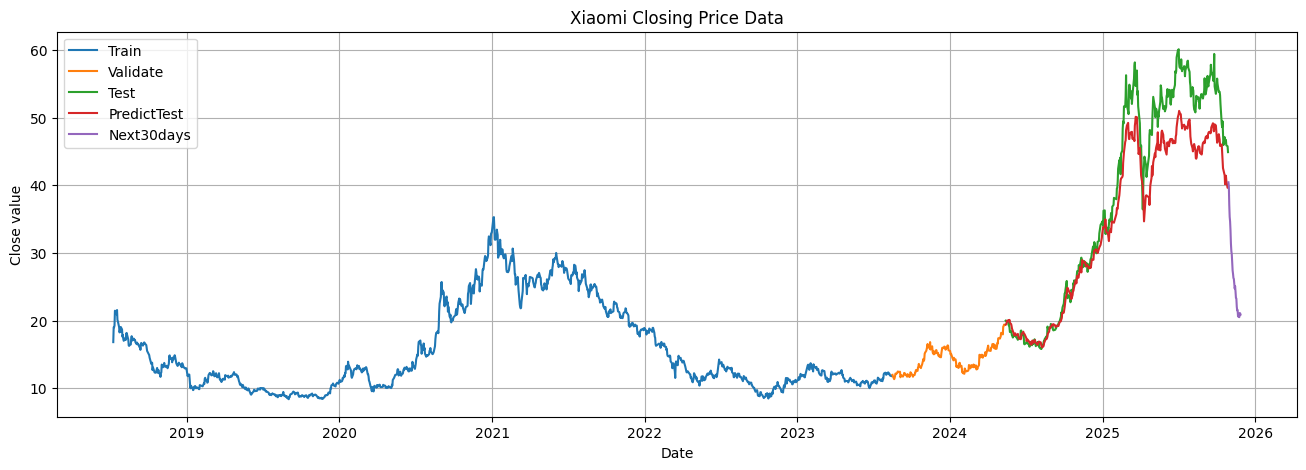

In [23]:
# Visualization
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], test_data)
plt.plot(df.index[train_size + val_size : ], y_pred)

plt.plot(future_dates, prediction_next30_days)

plt.legend(['Train', 'Validate', 'Test', 'PredictTest', 'Next30days'])

plt.grid()
plt.title(f"Xiaomi Closing Price Data")
plt.xlabel("Date")
plt.ylabel("Close value")
#plt.savefig('../Image/DNN_712_Xiaomi.png')
plt.show()